**Imports**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import json
import networkx as nx
import numpy as np
import pandas as pd

from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm_notebook, tqdm
from collections import Counter, defaultdict
import pickle
import community
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode, plot
init_notebook_mode(connected=True)
from utils import *

**Loading graph and vectors datasets**

In [5]:
G = nx.read_gml('../Datasets/Political Blogs/polblogs.gml').to_undirected()

polit_vect = {}
for key, value in dict(G.nodes(data=True)).items():
    appending = 0
    if int(value['value']) == 0:
        appending = 1
    polit_vect.update({key: np.asarray([int(value['value']), appending])})
    
vect = polit_vect

print('Number of nodes - {0}, Number of edges - {1}'.format(G.number_of_nodes(), G.number_of_edges()))

Number of nodes - 1490, Number of edges - 16718


**Removing nodes without features**

In [6]:
nodes = list(G.nodes)

for node in nodes:
    if node not in vect:
        G.remove_node(node)
        
print('Number of nodes - {0}, Number of edges - {1}'.format(G.number_of_nodes(), G.number_of_edges()))

Number of nodes - 1490, Number of edges - 16718


**Removing nodes without edges**

In [7]:
nodes = list(G.nodes)
for node in nodes:
    degree = G.degree(node)
    if degree == 0:
        G.remove_node(node)
        
print('Number of nodes - {0}, Number of edges - {1}'.format(G.number_of_nodes(), G.number_of_edges()))

Number of nodes - 1224, Number of edges - 16718


**Calculating significance normalization & common interests statistics**

In [8]:
significance_normalized_vect, omega = significance_normalization(vect)

_, mu, sigma = calc_common_interests_stats(G, vect)
mu, sigma

(0.9057901662878335, 0.2921204219908161)

**Names for features**

In [9]:
names = 'liberal', 'conservative'

**Creating weighted graph**

In [9]:
modified_G = G.copy()

for e in modified_G.edges():
    modified_G[e[0]][e[1]]['weight'] = 1
    
print('Graph is weighted - {0}'.format(nx.is_weighted(modified_G)))

Graph is weighted - True


**If topology is not fixed and similarity matrix file doesn't exist, then calculating similarity matrix and saving it in the file**

In [10]:
fixed_topology = True
similarity_file_exists = True

similarity_matrix_file_name = 'similarity_matrix_polit_cos.txt'
if (fixed_topology == False and similarity_file_exists == False):
    not_fixed_topology_graph(G, vect, omega, hamming_sim, similarity_matrix_file_name)  

**If topology is not fixed, then add edges to the top K neighbors of each node with zero weight, if there was no edge before**

In [11]:
top_k_neighbors = 9

if fixed_topology == False:
    sim_file = open(similarity_matrix_file_name,"r")

    for line in tqdm_notebook(sim_file, total=len(G.nodes()), leave=False):
        sim_tuple = eval(line)
        node = sim_tuple[0]
        for i in range(top_k_neighbors):
            if (not modified_G.has_edge(node, sim_tuple[1][i+1][0])):
                modified_G.add_edge(node, sim_tuple[1][i+1][0], weight=0)
    sim_file.close()

**Detecting communities and metrics calculation, based on input parameters**

In [17]:
similarity_metrics = [cosine_sim]#, manhattan_sim
alphas =  np.arange(0,1.05,0.05)
metric_names = ['cosine_sim']#, 'manhattan_sim'
gaussian_weighting = [False]
algorithm = ['louvain']#, 'node2vec']
metrics_report = []
clusters = 0
partition = []
clusters_set = []
partitions_set = []

for n, similarity in enumerate(tqdm_notebook(similarity_metrics)):
    for alpha in tqdm_notebook(alphas, leave=False):
        for k, gaussian in enumerate(tqdm_notebook(gaussian_weighting, leave=False)):
            for algo in algorithm:
                fname = 'algorithm-{}||metric_name-{}||alpha-{}||gaussian_weighting-{}'.format(algo, metric_names[n], alpha, gaussian_weighting[k])
 
                report,clusters,G,vect,partition = calculate_metrics(G, modified_G, G, vect, names, significance_normalized_vect, mu, sigma, omega, similarity, alpha, gaussian, fname=fname, algo=algo, viz=False)


                report['metric_name'] = metric_names[n]
                report['alpha'] = alpha
                report['gaussian_weighting'] = gaussian
                report['algorithm'] = algo
                metrics_report.append(report)
                clusters_set.append(clusters)
                partitions_set.append(partition)

### Plot communities

In [65]:
import matplotlib as mpl
import matplotlib.cm as cm

In [66]:
clust_cons = clusters_set[0][0]
clust_lib = clusters_set[0][2]

G_cons = G.subgraph(clust_cons)
G_lib = G.subgraph(clust_lib)

comm_nodes = list(G_cons.nodes())
lib_nodes = list(G_lib.nodes())

color_map = []
langs_color = []
for node in G_cons:
    if vect[node][0] == 1:
        color_map.append(cm.tab10(3))
    else:
        color_map.append(cm.tab10(0))
        
color_map_lib = []
langs_color = []
for node in G_lib:
    if vect[node][0] == 1:
        color_map_lib.append(cm.tab10(3))
    else:
        color_map_lib.append(cm.tab10(0))

In [68]:
options = {
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 10,
    'width': 0.01,
}

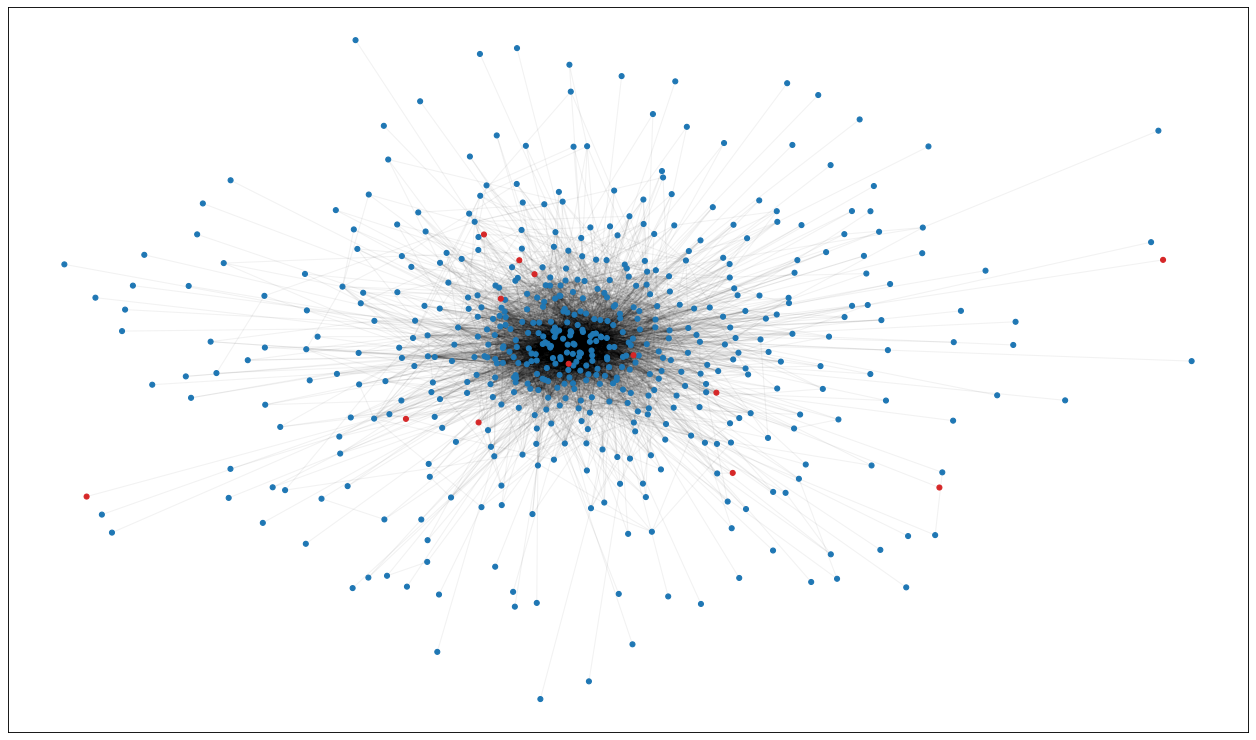

In [71]:
plt.figure(figsize=(20,12), dpi= 80)
pos = nx.spring_layout(G_cons)
ec = nx.draw_networkx_edges(G_cons, pos, alpha=0.05)
nc = nx.draw_networkx_nodes(G_cons, pos, nodelist=clust_cons, node_color=color_map, 
                            with_labels=False, node_size=20, cmap=plt.cm.tab10)


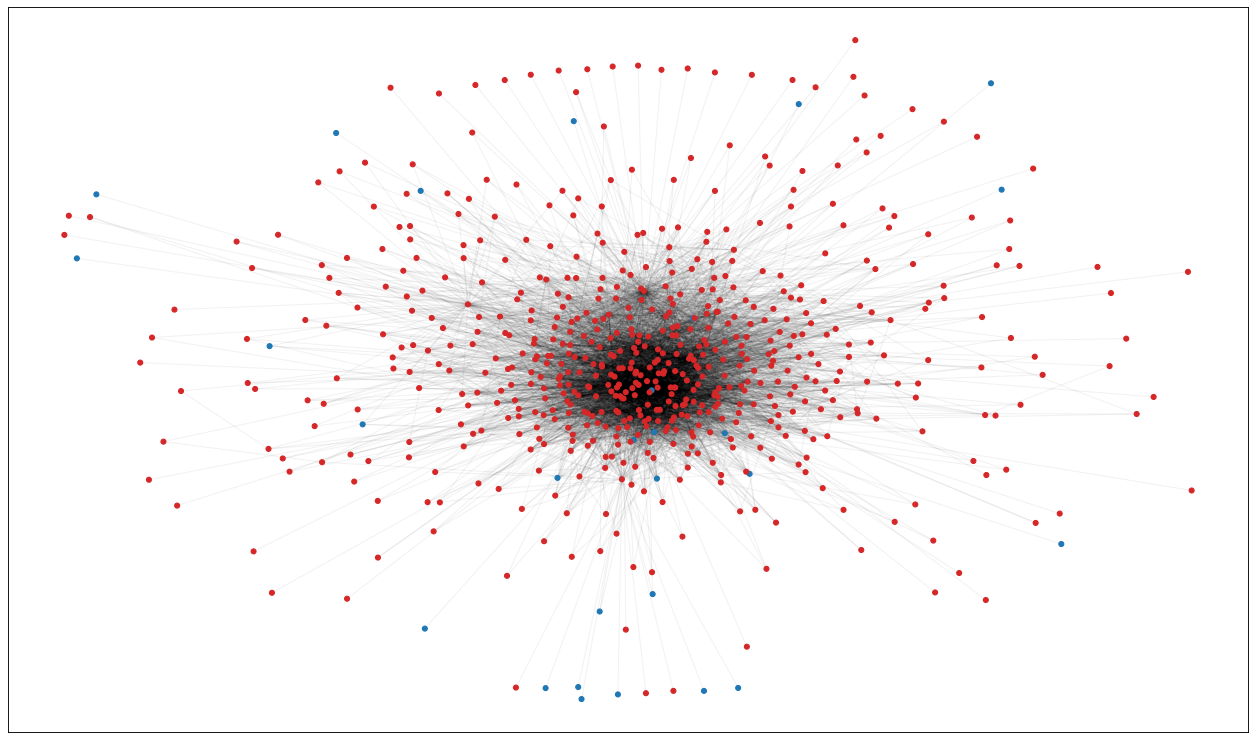

In [72]:
plt.figure(figsize=(20,12), dpi= 80)
pos = nx.spring_layout(G_lib)
ec = nx.draw_networkx_edges(G_lib, pos, alpha=0.05)
nc = nx.draw_networkx_nodes(G_lib, pos, nodelist=clust_lib, node_color=color_map_lib, 
                            with_labels=False, node_size=20, cmap=plt.cm.tab10)

### Save results 

In [14]:
topology = 'nf' #f - fixed, nf - not fixed
sim = 'cos' #cos - cosine similarity, hamm - hamming similarity
top_k = '5' #kpercent - top k percent
dataset = 'polit' #dataset name
result_file_name = dataset+'_'+sim+'_'+topology+top_k+'.txt'
hs = open(result_file_name,'w+')
hs.write(str(metrics_report))
hs.close()

### Load results

In [15]:
hs = open(result_file_name,'r')

for line in hs:
    metrics_report_fixed = eval(line)


In [16]:
mods_mean = []
mods_std = []
ents_mean = []
ents_std = []
taus_mean = []
taus_std = []
perms_mean = []
perms_std = []
harms_mean = []
harms_std = []
dens_mean = []
dens_std = []
for i in metrics_report_fixed:
    mods_mean.append(i['modularity_mean'])
    ents_mean.append(1 - i['graph_entropy_mean'])
    taus_mean.append(i['tau_mean'])
    perms_mean.append(i['permanence_mean'])
    harms_mean.append(i['cluster_harmony_mean'])
    dens_mean.append(i['cluster_density_mean'])
    mods_std.append(i['modularity_std'])
    ents_std.append(i['graph_entropy_std'])
    taus_std.append(i['tau_std'])
    perms_std.append(i['permanence_std'])
    dens_std.append(i['cluster_density_std'])
    harms_std.append(i['cluster_harmony_std'])
    

In [24]:
trace0 = go.Scatter(
    x = alphas,
    y = mods_mean,
    error_y=dict(type='data', array=mods_std),
    mode = 'lines',
    name = 'modularity'
)
trace1 = go.Scatter(
    x = alphas,
    y = ents_mean,
    error_y=dict(type='data', array=ents_std),
    mode = 'lines+markers',
    name = 'entropy',
    yaxis='y2'
)

data = [trace0, trace1]

layout = go.Layout(
    title='Modularity vs Entropy',
    yaxis=dict(
        title='Modularity'
    ),
    yaxis2=dict(
        title='Entropy',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    ),
        xaxis=dict(
        title=r'$\alpha$'
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()
